Classes found: ['Normal', 'Tumor']
Normal: 5077 images
Tumor: 2283 images
Sample image shape: (512, 512, 3)
Sample image dtype: uint8


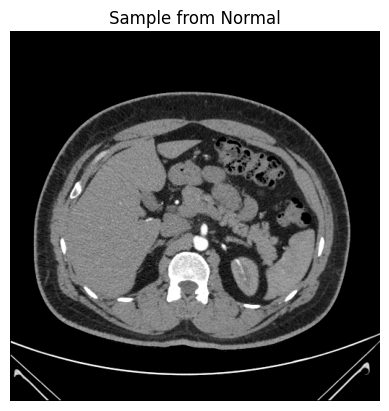

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "C:/Users/Krishnakanth S/detect kidney conditions/CT_KIDNEY_DATASET"  # Replace with your actual path

# List subdirectories (classes)
classes = os.listdir(dataset_path)
print("Classes found:", classes)

# Count images per class
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} images")

# Load a sample image to check format and size
sample_image_path = os.path.join(dataset_path, classes[0], os.listdir(os.path.join(dataset_path, classes[0]))[0])
sample_image = cv2.imread(sample_image_path)
print("Sample image shape:", sample_image.shape)
print("Sample image dtype:", sample_image.dtype)

# Display the sample image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title(f"Sample from {classes[0]}")
plt.axis("off")
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the path to your dataset
dataset_path = "C:/Users/Krishnakanth S/detect kidney conditions/CT_KIDNEY_DATASET"  # Replace with your actual path
IMG_SIZE = (224, 224)  # Define image size (224x224 is standard for many CNNs)

# Verify the path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset path {dataset_path} does not exist. Please check the directory.")

# Define data generator with preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.3  # 30% for validation + test (we’ll adjust for test set later)
)

# Training generator (70% of data)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',  # Use 'categorical' if more than 2 classes
    subset='training',
    shuffle=True
)

# Validation generator (15% of data initially, but we’ll refine this)
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Print number of samples
print("Training samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)

Found 5153 images belonging to 2 classes.
Found 2207 images belonging to 2 classes.
Training samples: 5153
Validation samples: 2207


Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Pixel value range: 0.0 to 1.0
Class names: ['Normal', 'Tumor']


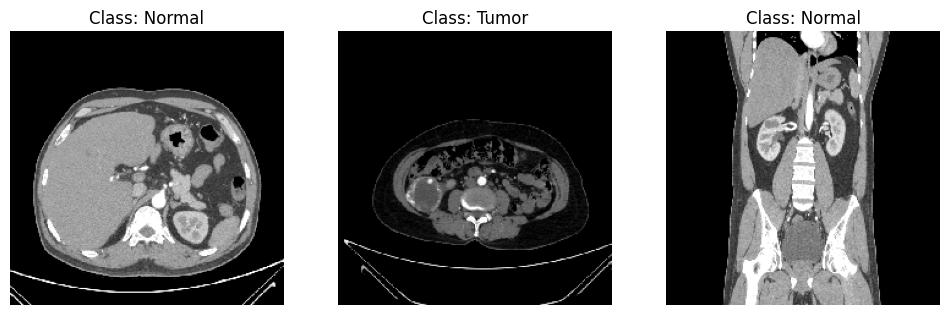

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Print shapes and ranges to verify preprocessing
print("Batch images shape:", images.shape)  # Should be (32, 224, 224, 3) with batch_size=32
print("Batch labels shape:", labels.shape)  # Should be (32,) for binary or (32, n_classes) for categorical
print("Pixel value range:", images.min(), "to", images.max())  # Should be 0.0 to 1.0 due to rescale=1./255

# Map class indices to names (based on folder names)
class_names = list(train_generator.class_indices.keys())  # e.g., ['Normal', 'Tumor']
print("Class names:", class_names)

# Visualize the first 3 images in the batch
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].imshow(images[i])  # Images are already normalized and in RGB format
    label_idx = int(labels[i]) if train_generator.class_mode == 'binary' else np.argmax(labels[i])
    axes[i].set_title(f"Class: {class_names[label_idx]}")
    axes[i].axis("off")
plt.show()

In [10]:
# Import necessary libraries for model building and training
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [11]:
# Define image size to match preprocessing (224x224 is standard for VGG16)
IMG_SIZE = (224, 224)

In [12]:
# Load pre-trained VGG16 model without top layers
# Weights from ImageNet, input shape matches our resized images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers to use pre-trained weights
base_model.trainable = False

In [13]:
# Create a sequential model by adding custom layers on top of VGG16
model = Sequential([
    base_model,              # Pre-trained VGG16 base
    Flatten(),              # Convert 2D feature maps to 1D vector
    Dense(128, activation='relu'),  # Fully connected layer with ReLU
    Dropout(0.5),           # Dropout to prevent overfitting (50% drop)
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Note: If you have more than 2 classes (e.g., Normal, Tumor, Cyst), use:
# Dense(3, activation='softmax') instead

In [14]:
# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Small learning rate for fine-tuning
    loss='binary_crossentropy',           # For binary classification
    metrics=['accuracy']                  # Track accuracy during training
)

# If multi-class (e.g., 3 classes), use:
# loss='categorical_crossentropy'

In [15]:
# Display the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Calculate steps per epoch based on dataset size and batch size
train_steps = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size

# Ensure at least 1 step even if dataset is smaller than batch size
if train_steps == 0:
    train_steps = 1
if val_steps == 0:
    val_steps = 1

# Print to verify
print(f"Training samples: {train_generator.samples}, Steps per epoch: {train_steps}")
print(f"Validation samples: {val_generator.samples}, Validation steps: {val_steps}")

Training samples: 5153, Steps per epoch: 161
Validation samples: 2207, Validation steps: 68


In [17]:
# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,    # Number of batches per epoch
    epochs=10,                      # Train for 10 epochs (adjust as needed)
    validation_data=val_generator,
    validation_steps=val_steps      # Validation batches per epoch
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 855s 5s/step - accuracy: 0.8426 - loss: 0.3398 - val_accuracy: 0.7247 - val_loss: 0.5922
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 1.0000 - loss: 0.0509 - val_accuracy: 0.7247 - val_loss: 0.5973
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1112s 7s/step - accuracy: 0.9941 - loss: 0.0465 - val_accuracy: 0.7578 - val_loss: 0.5733
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.7564 - val_loss: 0.5755
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 873s 5s/step - accuracy: 0.9998 - loss: 0.0168 - val_accuracy: 0.7688 - val_loss: 0.5985
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.7748 - val_loss: 0.5912
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.7394 - val_loss: 0.6754
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 1.0000 - loss: 0.0059 - val_acc

In [18]:
# Save the trained model
model.save('kidney_tumor_model.h5')
print("Model saved as 'kidney_tumor_model.h5'")

Model saved as 'kidney_tumor_model.h5'


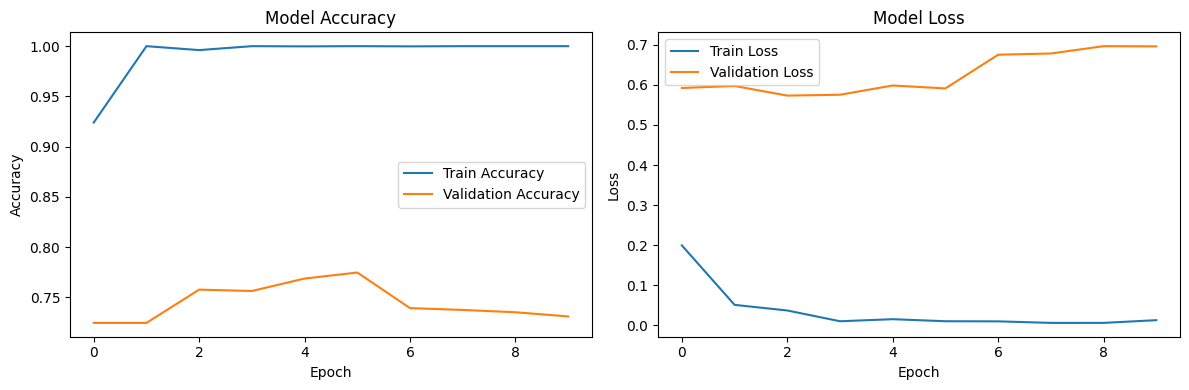

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.models import load_model
import cv2  # Import OpenCV
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def preprocess_image(image_path):
    # Load the image in RGB format
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Image could not be loaded. Check the file path.")
    
    # Resize to 224x224
    img = cv2.resize(img, (224, 224))
    # Convert BGR (OpenCV default) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize to [0, 1]
    img = img.astype('float32') / 255.0
    # Expand dimensions to match model input (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    return img

In [14]:
# Load the trained model
model = load_model('kidney_tumor_model.h5')
print("Model loaded successfully")

Model loaded successfully


In [15]:
import os
print(os.getcwd())  # Current directory
print(os.path.exists('kidney_tumor_model.h5'))  # Should be True

c:\Users\Krishnakanth S\detect kidney conditions
True


In [18]:
# Specify the path to your test image
test_image_path = "C:/Users/Krishnakanth S/detect kidney conditions/CT_KIDNEY_DATASET/Normal/Normal- (4).jpg"

# Preprocess the image
try:
    test_image = preprocess_image(test_image_path)
    print("Image preprocessed successfully")
except ValueError as e:
    print(e)
    raise

# Make prediction
prediction = model.predict(test_image)
print("Raw prediction:", prediction)

# Interpret the result (assuming binary classification)
class_names = ['Normal', 'Tumor']  # Adjust if you have more classes
pred_class = class_names[int(prediction[0][0] > 0.5)]  # Threshold at 0.5 for sigmoid
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
print(f"Predicted class: {pred_class}, Confidence: {confidence:.2f}")

Image preprocessed successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Raw prediction: [[0.00104062]]
Predicted class: Normal, Confidence: 1.00


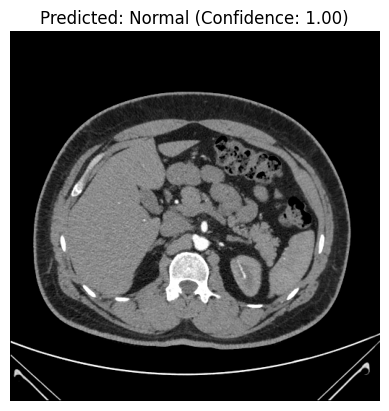

In [19]:
# Load and display the original image
img = cv2.imread(test_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title(f"Predicted: {pred_class} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Define dataset path (same as before)
dataset_path = "C:/Users/Krishnakanth S/detect kidney conditions/CT_KIDNEY_DATASET"

# Define image size (consistent with training)
IMG_SIZE = (224, 224)

# Create a generator for the full dataset (no split yet)
datagen = ImageDataGenerator(rescale=1./255)

# Load all data (we’ll split manually)
full_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',  # Adjust to 'categorical' if 3 classes
    shuffle=False  # Important for consistent evaluation
)

# Calculate sizes for train/val/test (70/15/15)
total_samples = full_generator.samples
train_size = int(0.70 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

print(f"Total samples: {total_samples}")
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

# Create test generator by skipping train and val samples
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',  # Adjust if needed
    shuffle=False,
    subset=None
)

# Note: We’ll limit predictions to the test portion later

Found 7360 images belonging to 2 classes.
Total samples: 7360
Train size: 5152, Validation size: 1104, Test size: 1104
Found 7360 images belonging to 2 classes.
